- 참고 링크

    - https://nbviewer.jupyter.org/github/SDRLurker/deep-learning/blob/master/5%E1%84%8C%E1%85%A1%E1%86%BC.ipynb<br>
밑바닥부터 시작하는 딥러닝1 책을 정리해놓은 위 링크를 참고

    - https://cs231n.github.io/convolutional-networks<br>


![](img/apple_forward1.png)
- 위 그림은 계산그래프를 활용한 왼쪽에서 오른쪽으로 진행하는 단계인 순전파 __forward propagation__
- 순전파는 계산 그래프의 출발점부터 종착점으로의 전파이다.
- 오른쪽에서 왼쪽으로의 전파는 __역전파__이며, 이에 대한 공부를 진행하겠다.
- 역전파는 이후, __미분을 계산할 때 중요한 역할을 한다.__

# 5. 오차역전파법
- 오차역전파법(backpropagation) : 가중치 매개변수의 기울기를 효율적으로 계산<br><br>
오차를 역(반대 방향)으로 전파하는 방법(backward propagation of errors)

##### 연쇄법칙(chain-rule) 이란?
연쇄 법칙, 즉 체인 룰이란 합성함수의 도함수에 대한 기본 공식이다.<br>
역전파(back propagation)에서 나타나는 합성함수의 편미분은 일일이 계산할 필요 없이 체인룰을 통해 간단히 계산 가능하다.

### 5.3 역전파
##### 5.3.1 덧셈 노드의 역전파
[단순한 편미분 활용] <br>
$z = x + y$ 의 미분. 다음은 해석적으로 계산

$$\frac{\partial z}{\partial x} = 1$$
$$\frac{\partial z}{\partial y} = 1$$
덧셈 노드의 역전파는 1을 곱하기만 할 뿐, 입력된 값을 그대로 다음 노드로 보내게 됨

##### 5.3.2 곱셈 노드의 역전파
$z = xy$의 미분

$$\frac{\partial z}{\partial x} = y$$
$$\frac{\partial z}{\partial y} = x$$
곱셈 노드의 역전파는 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보냄<br>
- 순전파 때 x 였다면, 역전파에서는 y <br>
- 순전파 때 y 였다면, 역전파에서는 x

## 5.4 단순한 계층 구현하기
계산 그래프의 곱셈 노드를 'MultiLayer', 덧셈 노드를 'AddLayer'로 구현

##### 5.4.1 곱셈 계층
> 다음 절에서는 신경망을 구성하는 계층 각각을 하나의 클래스로 구현한다. <br><br>
여기서의 계층이란, 신경망의 기능 단위이다.

모든 계층은 __forward() 순전파, backward() 역전파__ 라는 공통의 메서드(인터페이스)를 갖도록 구현

곱셈 계층을 __MultiLayer__클래스로 다음처럼 구현

In [9]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch05/layer_naive.py 소스 참고
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다
        dy = dout * self.x
        
        return dx, dy

## __책에 나온 사과 예제 활용__

In [10]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch05/buy_apple.py 소스 참고
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


__각 변수에 대한 미분은 backward()로 구할 수 있다.__

In [11]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax) # 2.2 110 200

2.2 110.00000000000001 200


![](img/5-4-1.png)

> backward() 호출 순서는 forward() 때와 반대<br><br>
backward()가 받는 인수는 __순전파의 출력에 대한 미분__

##### 5.4.2 덧셈 계층
덧셈 계층을 __MultiLayer__ 클래스
- 위에서 언급했듯이, 덧셈 계층에서는 미분을 해도 값이 그대로이므로 , 상류에서 넘어온 미분(dout)을 그대로 하류로 흘림

In [15]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [16]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch05/buy_apple.py 소스 참고
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price)) # 715
print("dApple:", dapple) # 2.2
print("dApple_num:", int(dapple_num)) # 110
print("dOrange:", dorange) # 3.3
print("dOrange_num:", int(dorange_num)) # 165
print("dTax:", dtax) # 650

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


![](img/5-4-2.png)

## 5.5 활성하 함수 계층 구현하기
활성화 함수인 __ReLU__와 __Sigmoid__ 계층을 구현

##### 5.5.1 ReLU 계층<br>
__식 5.7 ReLU 식__
$$y = x(x > 0)$$
$$y = 0(x <= 0$$

__식 5.8 ReLu x에 대한 y 미분 식__
$$\frac{\partial y}{\partial x} = 1 (x > 0)$$
$$\frac{\partial y}{\partial x} = 0 (x <= 0)$$

> 순전파 때 입력인 $x$가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘림<br><br>
순전파 때 $x$가 0 이하면 역전파 때는 하류로 신호를 보내지 않음


##### ReLU 계층을 구현한 코드

In [20]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/layers.py 소스 참고
class Relu:
    def __init__(self):
        self.mask = None
        
    def forawrd(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

Relu 클래스는 mask 인스턴스 변수를 가짐 <br>
mask는 순전파의 입력인 x의 원소 값이 0 이하인 인덱스는 True, 그 외 (0보다 큰 원소)는 False로 유지

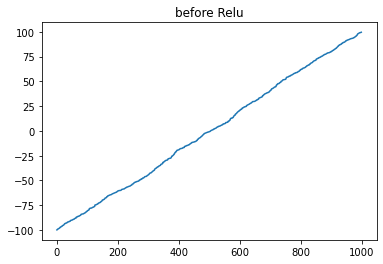

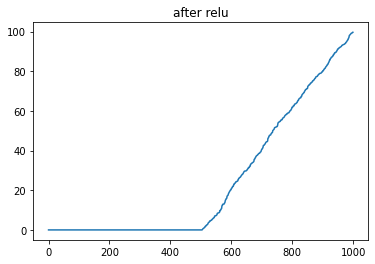

In [45]:
import random
import numpy as np


#랜덤으로 1000개 생성하여 확인
x = np.array([random.uniform(-100, 100) for i in range(1000)])

plt.plot(sorted(x))
plt.title('before Relu')
plt.show()

mask = (x <= 0)
out = x.copy()
out[mask] = 0


import matplotlib.pyplot as plt
plt.plot(sorted(out))
plt.title('after relu')
plt.show()

##### 5.5.2 Sigmoid 계층
__식 5.9 시그모이드 함수__
$$
y = \frac{1}{1 + exp(-x)}
$$
__식 5.10 은 위 시그모이드 함수를 y = 1/x__
$$
\frac{\partial y}{\partial x} = 1 (x > 0)
$$

- __위 식을 계산그래프로 그래면 아래와 같다.__
![](img/sigmoid1.png)

__exp__와 __/__ 노드가 새롭게 등장했다.<br>
__exp__ 노드는 __y = exp(x)__ 계산을 수행하고<br>
__/__ 노드는 __y = 1/x__ 계산을 수행한다.

__STEP01 :__ <br>
__/__ 노드를 미분하면 다음 식이 된다.
$$
\frac{\partial y}{\partial x} = -\frac{1}{x^2} = -y^2
$$
__계산 그래프에서는 아래와 같다.__
![](img/sigmoid2.png)

__STEP02 :__ <br>
__+__ 노드는 위에서 5.4.2 덧셈계층에서 언급되었듯이, 상류의 값을 여과 없이 하류로 보내면 끝<br>
__계산 그래프에서는 아래와 같다.__
![](img/sigmoid3.png)

__STEP03 :__<br>
exp 노드의 미분은 다음과 같다.
$$
\frac{\partial y}{\partial x} = exp(x)
$$
계산 그래프는 아래와 같다.
![](img/sigmoid4.png)

__STEP04 :__ <br>
__x__ 노드는 순전파 때의 값을 서로 바꿔 곱한다.
계산 그래프는 아래와 같다.
![](img/sigmoid5.png)

__※ 결국, 계산 그래프의 중간 과정을 모두 묶어 아래와 같은 단순한 sigmoid 노드 하나로 대체할 수 있다.__
![](img/sigmoid6.png)

> 계산 그래프의 간소화 버전은 역전파 과정의 중간 계산들을 생략할 수 있어 더 효율적인 계산이라 할 수 있다.<br>
또 노드를 그룹화하여 Sigmoid 계층의 세세한 내용을 노출하지 않고<br>
__입력과 출력에만 집중할 수 있다는 것도 중요한 포인트이다.__

최종적인 식은 아래와 같이 정리할 수 있다.
![](img/sigmoid7.png)

__이처럼 Sigmoid 계층의 역전파는 순전파의 출력 $y$ 만으로 계산할 수 있다.__
![](img/sigmoid8.png)

__Sigmoid 계층을 파이썬으로 구현__

In [46]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx